In [1]:
import pandas as pd
import os
import seaborn as sns
import xarray as xr
import numpy as np
import re
import statsmodels.api as sm
from datetime import datetime
import netCDF4 as nc
import matplotlib.pyplot as plt
from pkg import detrend_group, plot_twin_lines
import os
os.chdir("/Users/caropark/FAO_ag_check_code")

start = "/Users/caropark/Harvard University Dropbox/Caro Park/CropYield_VI_Global/DataByCountry/Italy"

In [2]:
def clean_masked_cal():
    
    key = pd.read_pickle("./data/calendar_fao_cropkey.pkl")
    idx = np.unique(key['harv_area_idx'].values)

    end_harvarea = "/harvest_area_fraction_data_sage_all.nc"

    if os.path.exists(start+end_harvarea):
        harvarea = xr.open_dataset(start+end_harvarea)['harvest_area_frac_nearest']
    else:
        print(f"harv_area not found. skipping...")
        return None, None
    
    harvarea = xr.open_dataset(start+end_harvarea)['harvest_area_frac_nearest']
    harvarea['location']= harvarea['location']+0
    harvarea['crop'] = harvarea['crop']+0
    harvarea = harvarea.sel(crop=idx).where(harvarea>0)

    counts = harvarea.groupby('crop').count(...)
    counts = counts.where(counts>0, drop=True)['crop'].values
    
    if counts.size == 0:
        print("Terminating: No valid crops found (counts.size == 0)")
        return None, None  # exit

    wanted = key[key['harv_area_idx'].isin(counts)]['crop'].values
    harvarea = harvarea.rename({"crop": "harv_area_idx"})
    harvarea = harvarea.where(harvarea.harv_area_idx.isin(counts), drop=True)

    harvarea = harvarea.to_dataframe().reset_index().merge(key[["crop", 'harv_area_idx']], how="left").set_index(['crop', 'location']).to_xarray()
    harvarea['location']= harvarea['location']+0
    harvarea['crop'] = harvarea['crop']+0

    end_cal = '/crop_calendar_data_sage.nc'
    end_harvarea = "/harvest_area_fraction_data_sage_all.nc"


    if os.path.exists(start+end_cal):
        calendar = xr.open_dataset(start+end_cal)
    else:
        print(f"crop cal not found. skipping...")
        return None, None
    
    calendar = xr.open_dataset(start+end_cal)
    calendar['location'] = calendar['location']+0
    calendar['crop']= calendar['crop']+0

    if np.sum(calendar.values) == 0:
        print("Terminating: Calendar data is empty (sum(calendar.values) == 0)")
        return None, None  # exit

    xry = harvarea.merge(calendar, join="left")[["plant", "harvest", "harvest_area_frac_nearest"]]
    xry['plant']= np.ceil(xry['plant']).astype(int)
    xry['harvest']= np.ceil(xry['harvest']).astype(int)
    xry = xry.where(xry != 0)
    xry['plant']= (np.datetime64("1999-12-31") + xry['plant'].astype("timedelta64[D]")).dt.month
    xry['harvest']= (np.datetime64("1999-12-31") + xry['harvest'].astype("timedelta64[D]")).dt.month
    xry['plant']= xr.where(xry['harvest'] < xry['plant'], xry.plant-12, xry.plant)
    xry = xry.where(xry['harvest_area_frac_nearest'].notnull(), drop=True)

    return(harvarea, xry)

In [3]:
def get_growing_szn(xry):
    xry = xry.where(xry['plant'].notnull(), drop=True)
    xry_df = xry.to_dataframe().reset_index() 

    plant = xry['plant'].values.flatten()
    harvest = xry['harvest'].values.flatten()

    def unique_pairs(a, b):
        c = np.sort(np.stack([a, b], axis = 1), axis = 1)
        c_view = np.ascontiguousarray(c).view(np.dtype((np.void,
                                              c.dtype.itemsize * c.shape[1])))
        _, i = np.unique(c_view, return_index = True)
        return a[i].astype(np.int64), b[i].astype(np.int64)

    heya = unique_pairs(plant, harvest)
    lst = [list(range(i, j+1)) for i, j in zip(heya[0], heya[1])]

    if 0 in lst:
        lst.remove([0])

    growszn = pd.DataFrame({'month':lst,
                 'plant': [xi[0] for xi in lst],
                 'harvest': [xi[-1] for xi in lst],
                           'growing': 1}).explode('month')

    ok = xry_df.merge(growszn, how="left").set_index(['month', 'location', 'crop']).to_xarray()
    growmonths = ok.where(ok['growing']>0, drop=True)
    
    return(growmonths)

In [4]:
def merge_sif(growmonths):
    end_fao = '/fao_data.nc'
    end_sif = '/csif_data_updated.nc'
    fao = xr.open_dataset(start+end_fao, drop_variables="crop")
    sif = xr.open_dataset(start+end_sif)
    sif['location']= sif['location']+0
    sif = sif.where(sif['csif']>0) 
    sif['month']= sif['month']+1
    sif_shift = sif.copy().shift(year=1)
    sif_shift['month'] = sif_shift['month']-12
    sif_comb = xr.merge([sif, sif_shift])
    
    sifmerged = xr.merge([growmonths, sif_comb], join="left")
    
    return(sifmerged)

In [5]:
def sifmeans_n_fao(sifmerged):
    test = sifmerged[['csif', 'harvest_area_frac_nearest']].where(sifmerged['plant'].notnull(), drop=True).stack(hello=('crop', 'year'))
    test['harvest_area_frac_nearest']= test['harvest_area_frac_nearest'].fillna(0)
    test['csif_w']= test['csif'].weighted(test['harvest_area_frac_nearest']).mean(["month", "location"])
    
    sifvals= test['csif'].values
    sifvals = sifvals.reshape(sifvals.shape[0]*sifvals.shape[1], sifvals.shape[2])
    gridcells = ((~np.isnan(sifvals)) & (sifvals>0)).sum(0)

    df = test['csif_w'].to_dataframe().reset_index(drop=True)
    df['gridcells'] = gridcells
 
    end_fao = '/fao_data_updated.nc'
    fao = xr.open_dataset(start+end_fao).drop('country').sel(year=slice(2000,2024))[['yield']]
    key = pd.read_pickle("./data/calendar_fao_cropkey.pkl")
    croplist = key['item'].unique().tolist()
    fao = fao.sel(crop=croplist)
    faoy = fao.to_dataframe().reset_index().rename({"crop": "item"}, axis=1)
    faoy= faoy.merge(key, how="left").dropna()
    df = df.merge(faoy, how="left").reset_index(drop=True)
    df = df[df['yield'].notna()]
    df = df[df['gridcells']>0].drop(columns="item")    
    return(df)

In [6]:
def avg_2crops_n_lags(df):
    grids = df.groupby(['year', 'fao_idx', 'cropname', 'yield'])['gridcells'].sum('gridcells').reset_index()
    test = df.groupby(['year', 'fao_idx', 'cropname', 'yield']).apply(lambda x: np.average(x['csif_w'], weights=x['gridcells'])).reset_index().rename({0:"csif"}, axis=1)
    test['country'] = start.rsplit('/',1)[1]
    ugh = test.merge(grids, how="left")

    return(ugh)

In [7]:
def fixed_lags(df):
    df = df.rename({"yield": "yield_og", "csif": "csif_og"},axis=1)
    df = detrend_group(df, "yield_og", "yield_log_dt", log_transform=True)
    df = detrend_group(df, "csif_og", "csif_log_dt", log_transform= True)
    df['yield_lag'] = df.groupby(['cropname', 'country'])['yield_log_dt'].shift(1)
    df['yield_lead'] = df.groupby(['cropname','country'])['yield_log_dt'].shift(-1)

    corrs = (df.groupby(["cropname", "country"])
        .apply(lambda g: g[["yield_log_dt", "yield_lag", "yield_lead"]].corrwith(g["csif_log_dt"]) if len(g) >= 2 else None).dropna())
    corrs = corrs.idxmax(axis=1).to_frame().reset_index().rename({0: 'whichlag'}, axis=1)

    df = df.merge(corrs)
    df['name'] = np.where(df.whichlag == "yield_log_dt", df.country, df.country + " (" + (df.whichlag).str.replace("yield_", "") + ")")

    df["yield_log_dt"] = np.select(
        [df["whichlag"] == "yield_lead",
        df["whichlag"] == "yield_lag"],

        [df["yield_lead"],
            df["yield_lag"]],
        default= df["yield_log_dt"])

    return df

In [12]:
def run_like_hocker():
    harvarea, xry = clean_masked_cal()

    if harvarea is None or xry is None:
        print("no crop calendar or harvested area")
        return None  

    growmonths = get_growing_szn(xry)
    sifmerged = merge_sif(growmonths)
    df = sifmeans_n_fao(sifmerged)
    ugh = avg_2crops_n_lags(df)
    ugh = fixed_lags(ugh)
    return ugh

In [13]:
%%time
ugh = run_like_hocker()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_90537/3139334215.py:13: RuntimeWarning: invalid value encountered in cast
  return a[i].astype(np.int64), b[i].astype(np.int64)


CPU times: user 1.63 s, sys: 1.11 s, total: 2.74 s
Wall time: 3.12 s


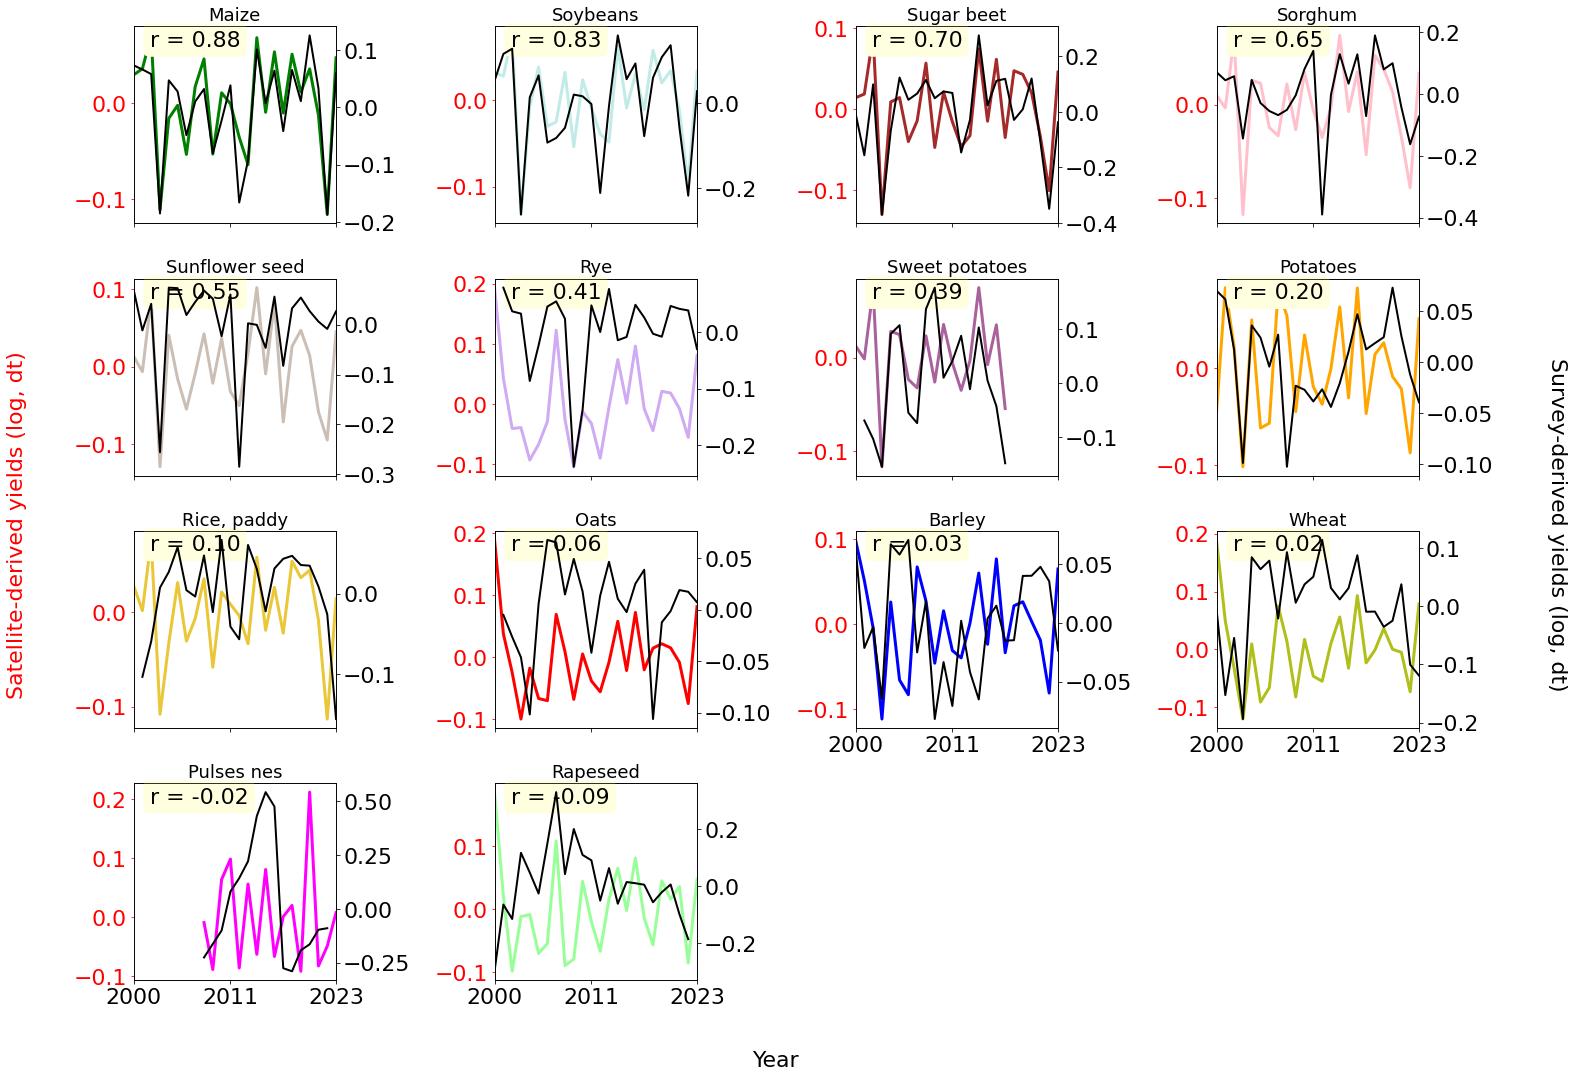

In [14]:
colors1 = ["blue", "green", "red", "orange", "#98ff98", "#eac736", "#d0aaf3", "pink", "#c0ebe7", "brown", "#cbbeb5", "#aa629c", "#b0bf1a", "#ff00ff", "#9bd18c", "#2acaea"]
plot_twin_lines(ugh, col="cropname", col_wrap=4, 
                grid_kwargs={"hue":"cropname", 'palette': colors1}, plot_kwargs= None, filename="DELETE")